<a href="https://colab.research.google.com/github/mjgpinheiro/Physics_models/blob/main/MRSI_BTCUSDT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[*********************100%***********************]  1 of 1 completed


Final Balance: 4108.703125
Trading duration: 44135.00 minutes
Trade Log:
('BUY', 58946.9375, Timestamp('2024-08-04 20:35:00+0000', tz='UTC'))
('SELL', 58995.8828125, Timestamp('2024-08-04 21:05:00+0000', tz='UTC'))
('BUY', 58948.33203125, Timestamp('2024-08-04 21:15:00+0000', tz='UTC'))
('SELL', 58674.0703125, Timestamp('2024-08-04 21:20:00+0000', tz='UTC'))
('SELL', 52385.74609375, Timestamp('2024-08-05 07:20:00+0000', tz='UTC'))
('BUY', 52905.59765625, Timestamp('2024-08-05 07:40:00+0000', tz='UTC'))
('BUY', 54134.64453125, Timestamp('2024-08-05 16:55:00+0000', tz='UTC'))
('SELL', 53834.67578125, Timestamp('2024-08-05 17:05:00+0000', tz='UTC'))
('SELL', 54252.515625, Timestamp('2024-08-05 20:05:00+0000', tz='UTC'))
('BUY', 53691.75, Timestamp('2024-08-05 20:15:00+0000', tz='UTC'))
('BUY', 54516.01171875, Timestamp('2024-08-05 23:30:00+0000', tz='UTC'))
('SELL', 54289.37890625, Timestamp('2024-08-05 23:45:00+0000', tz='UTC'))
('BUY', 55670.6953125, Timestamp('2024-08-06 03:20:00+0000'

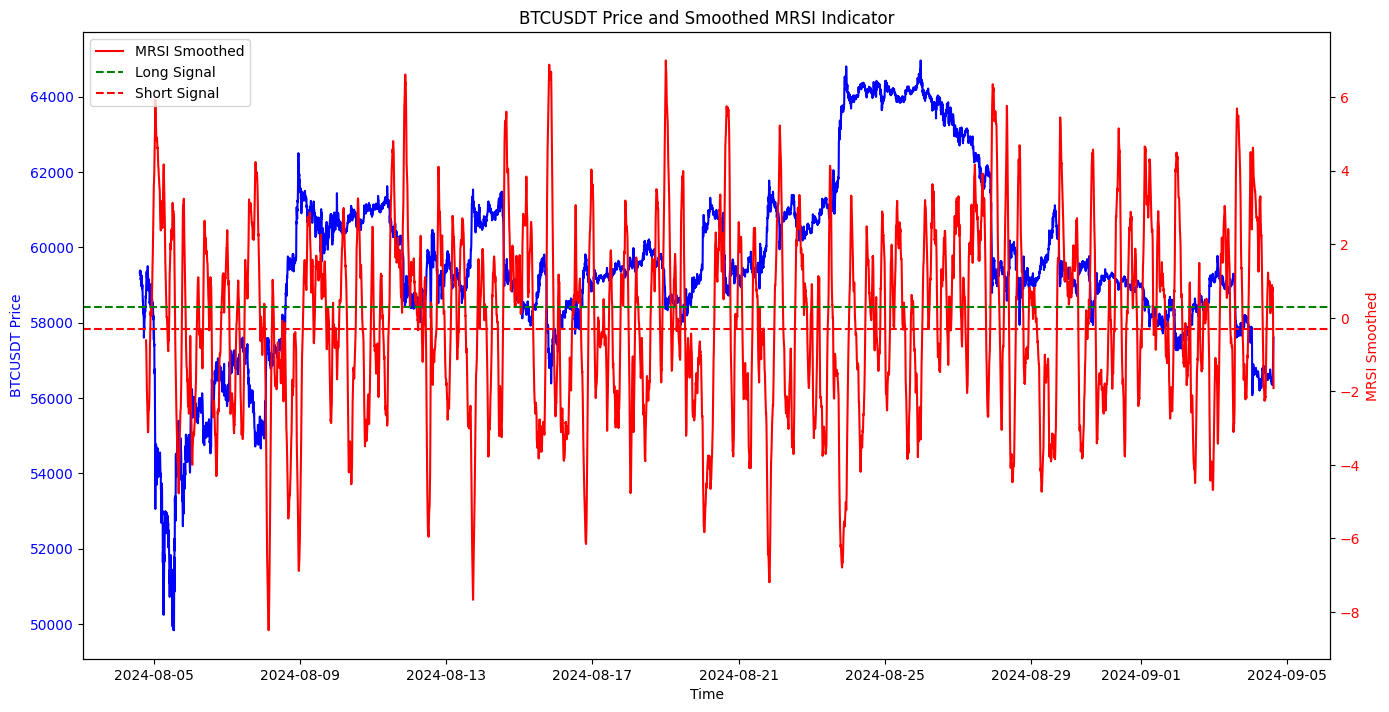

In [3]:
# Install necessary libraries (run these commands only once)
!pip install yfinance pandas_ta matplotlib

import yfinance as yf
import pandas as pd
import pandas_ta as ta
import numpy as np
import matplotlib.pyplot as plt
import itertools
import time

# Fetch BTCUSDT data from Yahoo Finance
def fetch_btcusdt_data():
    # Use a valid period like '1mo' for one month of data
    btc_data = yf.download('BTC-USD', interval='5m', period='1mo')  # '5m' interval for 5-minute data
    btc_data = btc_data.rename(columns={'Open': 'open', 'High': 'high', 'Low': 'low', 'Close': 'close', 'Volume': 'volume'})
    return btc_data

# Fetch BTCUSDT data
btc_futures_data = fetch_btcusdt_data()

# Adding ATR, RSI, MACD, Bollinger Bands, and Stochastic using pandas_ta
btc_futures_data['ATR'] = ta.atr(btc_futures_data['high'], btc_futures_data['low'], btc_futures_data['close'], length=14)
btc_futures_data['RSI'] = ta.rsi(btc_futures_data['close'], length=14)
btc_futures_data['MACD'] = ta.macd(btc_futures_data['close'], fast=12, slow=26, signal=9)['MACD_12_26_9']

# Correctly adding Bollinger Bands
bb_bands = ta.bbands(btc_futures_data['close'], length=20, std=2)
btc_futures_data['BB_upper'] = bb_bands['BBU_20_2.0']
btc_futures_data['BB_middle'] = bb_bands['BBM_20_2.0']
btc_futures_data['BB_lower'] = bb_bands['BBL_20_2.0']

# Adding Stochastic Oscillator
stoch = ta.stoch(btc_futures_data['high'], btc_futures_data['low'], btc_futures_data['close'], k=14, d=3)
btc_futures_data['StochK'] = stoch['STOCHk_14_3_3']
btc_futures_data['StochD'] = stoch['STOCHd_14_3_3']

# Function to calculate the dynamic MRSI indicator
def calculate_dynamic_mrsi(data, theta):
    mu = data['close'].rolling(window=50).mean()  # Using a longer rolling window for smoothing
    sigma = data['ATR']  # Use ATR as dynamic volatility
    deviation = mu - data['close']
    mrsi = theta * deviation / sigma
    return mrsi

# Example parameter values for MRSI calculation
theta = 0.8  # Adjusted Speed of mean reversion for more sensitivity

# Calculate MRSI and add to the DataFrame
btc_futures_data['MRSI'] = calculate_dynamic_mrsi(btc_futures_data, theta)

# Apply smoothing to MRSI
btc_futures_data['MRSI_Smoothed'] = btc_futures_data['MRSI'].ewm(span=15, adjust=False).mean()  # Adjusted EMA span

# Function for backtesting the enhanced MRSI strategy with additional indicators and dynamic risk management
def backtest_mrsi_strategy(data, entry_threshold=0.3, exit_threshold=0.1, stop_loss_factor=1.0, take_profit_factor=1.5, trail_stop_factor=1.0):
    initial_balance = 1800  # Starting balance in USDT
    balance = initial_balance
    position = 0  # 0: no position, 1: long, -1: short
    trade_log = []
    entry_price = 0
    trail_stop_price = None

    for i in range(1, len(data)):
        mrsi = data['MRSI_Smoothed'].iloc[i]
        rsi = data['RSI'].iloc[i]
        macd = data['MACD'].iloc[i]
        stoch_k = data['StochK'].iloc[i]
        stoch_d = data['StochD'].iloc[i]
        price = data['close'].iloc[i]
        atr = data['ATR'].iloc[i]

        # Dynamic stop-loss, take-profit, and trailing stop based on ATR
        stop_loss = stop_loss_factor * atr
        take_profit = take_profit_factor * atr
        trail_stop = trail_stop_factor * atr

        if position == 0:
            # Buy signal: MRSI < -threshold, RSI < 50, MACD > 0, Stochastic K < 20
            if mrsi < -entry_threshold and rsi < 50 and macd > 0 and stoch_k < 20:
                position = 1
                entry_price = price
                trail_stop_price = price - trail_stop
                trade_log.append(('BUY', price, data.index[i]))
            # Sell signal: MRSI > threshold, RSI > 50, MACD < 0, Stochastic K > 80
            elif mrsi > entry_threshold and rsi > 50 and macd < 0 and stoch_k > 80:
                position = -1
                entry_price = price
                trail_stop_price = price + trail_stop
                trade_log.append(('SELL', price, data.index[i]))

        elif position == 1:
            # Update trailing stop for long position
            if price - trail_stop > trail_stop_price:
                trail_stop_price = price - trail_stop

            # Sell if stop-loss, take-profit, trailing stop, or MRSI exit signal is hit
            if price <= entry_price - stop_loss or price >= entry_price + take_profit or price <= trail_stop_price or mrsi > exit_threshold:
                balance += price - entry_price
                position = 0
                trail_stop_price = None
                trade_log.append(('SELL', price, data.index[i]))

        elif position == -1:
            # Update trailing stop for short position
            if price + trail_stop < trail_stop_price:
                trail_stop_price = price + trail_stop

            # Buy to cover if stop-loss, take-profit, trailing stop, or MRSI exit signal is hit
            if price >= entry_price + stop_loss or price <= entry_price - take_profit or price >= trail_stop_price or mrsi < -exit_threshold:
                balance += entry_price - price
                position = 0
                trail_stop_price = None
                trade_log.append(('BUY', price, data.index[i]))

    return balance, trade_log

# Run backtesting
final_balance, trade_log = backtest_mrsi_strategy(btc_futures_data)
print(f"Final Balance: {final_balance}")

# Calculate trading duration if there were trades executed
if trade_log:
    # Extract the first and last timestamps from the trade log
    start_time = trade_log[0][2]  # Timestamp of the first trade
    end_time = trade_log[-1][2]  # Timestamp of the last trade

    # Calculate the duration in minutes
    duration_minutes = (end_time - start_time).total_seconds() / 60
    print(f"Trading duration: {duration_minutes:.2f} minutes")
else:
    print("No trades were executed.")

# Print the trade log
print("Trade Log:")
for trade in trade_log:
    print(trade)

# Plotting BTCUSDT price and MRSI using dual axes
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot BTCUSDT price
ax1.set_xlabel('Time')
ax1.set_ylabel('BTCUSDT Price', color='blue')
ax1.plot(btc_futures_data.index, btc_futures_data['close'], color='blue', label='BTCUSDT Price')
ax1.tick_params(axis='y', labelcolor='blue')

# Plot Smoothed MRSI on a secondary y-axis
ax2 = ax1.twinx()
ax2.set_ylabel('MRSI Smoothed', color='red')
ax2.plot(btc_futures_data.index, btc_futures_data['MRSI_Smoothed'], color='red', label='MRSI Smoothed')
ax2.tick_params(axis='y', labelcolor='red')

# Adding horizontal lines for MRSI signals
ax2.axhline(y=0.3, color='green', linestyle='--', label='Long Signal')
ax2.axhline(y=-0.3, color='red', linestyle='--', label='Short Signal')

# Titles and legends
fig.tight_layout()
plt.title('BTCUSDT Price and Smoothed MRSI Indicator')
plt.legend(loc='upper left')
plt.show()
